In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("DataCamp Online Retail").getOrCreate()
spark

In [15]:
df = spark.read.csv("OnlineRetail.csv", header=True, inferSchema=True, escape="\"")
df.show(5, 0)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------

 ### Exploratory Data Analysis

In [17]:
### How many rows we have
df.count()

541909

In [18]:
# How many unique customers do we have?
df.select("CustomerID").distinct().count()

4373

In [19]:
### Find which country purchased more?
from pyspark.sql.functions import *
from pyspark.sql.types import *
count_distinct = df.groupBy("Country").agg(countDistinct("CustomerID").alias("country_count"))
count_distinct.show()

+------------------+-------------+
|           Country|country_count|
+------------------+-------------+
|            Sweden|            8|
|         Singapore|            1|
|           Germany|           95|
|               RSA|            1|
|            France|           87|
|            Greece|            4|
|European Community|            1|
|           Belgium|           25|
|           Finland|           12|
|             Malta|            2|
|       Unspecified|            4|
|             Italy|           15|
|              EIRE|            3|
|         Lithuania|            1|
|            Norway|           10|
|             Spain|           31|
|           Denmark|            9|
|         Hong Kong|            0|
|           Iceland|            1|
|            Israel|            4|
+------------------+-------------+
only showing top 20 rows



In [20]:
# Order the country that has a lot of purchases Descendent order
count_distinct.sort("country_count", ascending=[False]).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [21]:
df.groupBy("Country").agg(countDistinct("CustomerID").alias("country_count")).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [22]:
## Find when the most recent purchased was made on the platform?
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY") # 12/1/2010 8:26
df = df.withColumn('date',to_timestamp("InvoiceDate", 'MM/dd/yyyy HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



In [23]:
# Find the earliest purchased done by the customer?
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



## Data Pre-Processing

In [24]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |from_date          |date               |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BO

In [25]:
# We have two factors needs to be take in consideration:
# 1- Recency: The most recent purchases done.
# ---> Assign a recency score to each customer
# 2- 

In [30]:
df = df.withColumn("from_date", lit("12/1/2010 08:26"))
df = df.withColumn("from_date", to_timestamp("from_date", "MM/dd/yyyy HH:mm"))
df2 = df.withColumn("from_date", to_timestamp(col("from_date"))).withColumn("recency", col("date").cast("long") - col("from_date").cast("long"))

df2.show(5, 0)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+-------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |from_date          |date               |recency|
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+-------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|0      |
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|0      |
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|0      |
|536

### 1- Select the most recent purchase

In [31]:
df2 = df2.join(df2.groupBy("CustomerID").agg(max("recency").alias("recency")), on="recency", how="leftsemi")
df2.show(5, 3)

+-------+---------+---------+-----------+--------+-----------+---------+----------+-------+---------+----+
|recency|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|from_date|date|
+-------+---------+---------+-----------+--------+-----------+---------+----------+-------+---------+----+
|    522|      536|      824|        WOO|       3|        12/|      6.4|       180|    Uni|      201| 201|
|    522|      536|      847|        COL|      48|        12/|      0.6|       180|    Uni|      201| 201|
|    522|      536|      224|        HAN|      12|        12/|      1.6|       180|    Uni|      201| 201|
|    522|      536|      213|        HAN|       6|        12/|      2.9|       180|    Uni|      201| 201|
|    522|      536|      224|        NAT|      12|        12/|      2.9|       180|    Uni|      201| 201|
+-------+---------+---------+-----------+--------+-----------+---------+----------+-------+---------+----+
only showing top 5 rows



In [32]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- date: timestamp (nullable = true)



### 2- Calculate the frequency

In [37]:
def_freq = df2.groupBy("CustomerID").agg(count("InvoiceDate").alias("frequency"))
def_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|15447     |9        |
|15100     |1        |
|13898     |12       |
|17950     |33       |
|16565     |3        |
+----------+---------+
only showing top 5 rows



In [40]:
df3 = df2.join(def_freq, on="CustomerID", how="inner")
df3.show(5,0)

+----------+-------+---------+---------+-----------------------------------+--------+--------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID|recency|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|Country       |from_date          |date               |frequency|
+----------+-------+---------+---------+-----------------------------------+--------+--------------+---------+--------------+-------------------+-------------------+---------+
|18074     |5220   |536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |12/1/2010 9:53|6.45     |United Kingdom|2010-12-01 08:26:00|2010-12-01 09:53:00|13       |
|18074     |5220   |536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |12/1/2010 9:53|0.65     |United Kingdom|2010-12-01 08:26:00|2010-12-01 09:53:00|13       |
|18074     |5220   |536384   |22464    |HANGING METAL HEART LANTERN        |12      |12/1/2010 9:53|1.65     |United Kin

In [41]:
df3.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



### 3- Monetary Value

In [45]:
## Calculate the total amount spent per customer
## Two Steps:
# 1- found the total amount spent in each purchase


In [44]:
m_val = df3.withColumn("TotalAmount", col("Quantity") * col("UnitPrice"))
m_val.show(5, 0)

+----------+-------+---------+---------+-----------------------------------+--------+--------------+---------+--------------+-------------------+-------------------+---------+------------------+
|CustomerID|recency|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|Country       |from_date          |date               |frequency|TotalAmount       |
+----------+-------+---------+---------+-----------------------------------+--------+--------------+---------+--------------+-------------------+-------------------+---------+------------------+
|18074     |5220   |536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |12/1/2010 9:53|6.45     |United Kingdom|2010-12-01 08:26:00|2010-12-01 09:53:00|13       |19.35             |
|18074     |5220   |536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |12/1/2010 9:53|0.65     |United Kingdom|2010-12-01 08:26:00|2010-12-01 09:53:00|13       |31.200000000000003|
|18074     |5220   |53638

In [46]:
# 2- find the total amount spent by each customer
m_val = m_val.groupBy("CustomerID").agg(sum("TotalAmount").alias("monetry_value"))
m_val.show(5,0)

+----------+-------------------+
|CustomerID|monetry_value      |
+----------+-------------------+
|15447     |155.17             |
|15100     |-32.849999999999994|
|13898     |155.93             |
|17950     |208.95             |
|16565     |173.7              |
+----------+-------------------+
only showing top 5 rows



In [62]:
# Merge the tow dataframes
final_df = m_val.join(df3, on="CustomerID", how="inner")
final_df.show(5,0)

+----------+-------------+-------+---------+---------+-----------------------------------+--------+--------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID|monetry_value|recency|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|Country       |from_date          |date               |frequency|
+----------+-------------+-------+---------+---------+-----------------------------------+--------+--------------+---------+--------------+-------------------+-------------------+---------+
|18074     |489.6        |5220   |536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |12/1/2010 9:53|6.45     |United Kingdom|2010-12-01 08:26:00|2010-12-01 09:53:00|13       |
|18074     |489.6        |5220   |536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |12/1/2010 9:53|0.65     |United Kingdom|2010-12-01 08:26:00|2010-12-01 09:53:00|13       |
|18074     |489.6        |5220   |536384   |22464 

In [63]:
# Select the necessery columns to build the column

In [64]:
final_df = final_df.select(['recency','frequency','monetry_value','CustomerID']).distinct()

In [65]:
# Standarization the dataframe
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [68]:
assembler = VectorAssembler(inputCols=["recency","frequency","monetry_value"], outputCol="features")
assembled_data = assembler.transform(final_df)
assembled_data.show()

+-------+---------+-------------------+----------+--------------------+
|recency|frequency|      monetry_value|CustomerID|            features|
+-------+---------+-------------------+----------+--------------------+
|3726000|        9|             155.17|     15447|[3726000.0,9.0,15...|
|3746580|        1|-32.849999999999994|     15100|[3746580.0,1.0,-3...|
|4154520|       12|             155.93|     13898|[4154520.0,12.0,1...|
| 716280|       33|             208.95|     17950|[716280.0,33.0,20...|
| 802500|        3|              173.7|     16565|[802500.0,3.0,173.7]|
|  97020|        1|              106.2|     15070| [97020.0,1.0,106.2]|
| 105180|       13| 248.10000000000002|     16510|[105180.0,13.0,24...|
| 621720|        5|             403.25|     15221|[621720.0,5.0,403...|
|1222740|        9| 422.70000000000005|     17525|[1222740.0,9.0,42...|
| 184560|        3|              39.75|     14589|[184560.0,3.0,39.75]|
|  25740|       67| 357.94999999999993|     16274|[25740.0,67.0,

In [69]:
scale = StandardScaler(inputCol='features', outputCol="standarized")
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)
data_scale_output.show()

+-------+---------+-------------------+----------+--------------------+--------------------+
|recency|frequency|      monetry_value|CustomerID|            features|         standarized|
+-------+---------+-------------------+----------+--------------------+--------------------+
|3726000|        9|             155.17|     15447|[3726000.0,9.0,15...|[0.42717941487700...|
|3746580|        1|-32.849999999999994|     15100|[3746580.0,1.0,-3...|[0.42953887605740...|
|4154520|       12|             155.93|     13898|[4154520.0,12.0,1...|[0.47630848703564...|
| 716280|       33|             208.95|     17950|[716280.0,33.0,20...|[0.08212025531081...|
| 802500|        3|              173.7|     16565|[802500.0,3.0,173.7]|[0.09200522824444...|
|  97020|        1|              106.2|     15070| [97020.0,1.0,106.2]|[0.01112317413616...|
| 105180|       13| 248.10000000000002|     16510|[105180.0,13.0,24...|[0.01205870393364...|
| 621720|        5|             403.25|     15221|[621720.0,5.0,403...

In [ ]:
### These data presented will be fitted to the clustering algorithm

In [70]:
data_scale_output.select("standarized").show(2, truncate=False)

+---------------------------------------------------------------+
|standarized                                                    |
+---------------------------------------------------------------+
|[0.42717941487700695,0.23237755599332738,0.0555092310302321]   |
|[0.4295388760574065,0.025819728443703043,-0.011751487010009179]|
+---------------------------------------------------------------+
only showing top 2 rows



### Building the ML Algorithm


In [73]:
"""The most important thing in this classification algorithm
is to determin how many clusters we need to use, and for this
we can use the "Elbow-Method"""

'The most important thing in this classification algorithm\nis to determin how many clusters we need to use, and for this\nwe can use the "Elbow-Method'

In [74]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

In [77]:
cost = np.zeros(10)
evaluator = ClusteringEvaluator(predictionCol='prediction', 
                               featuresCol='standarized',
                                metricName="silhouette",
                                distanceMeasure="squareEucliden"
                               )

In [78]:
for i in range(2,10):
    KMeans_algo = KMeans(featuresCol='standarized', k=i)
    KMeans_fit = KMeans_algo.fit(data_scale_output)
    output= KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

In [79]:
cost

array([    0.        ,     0.        , 11759.08202463,  6953.41931486,
        4290.92711421,  3278.37082879,  2773.67137352,  2349.48960819,
        2231.05705068,  2084.5157455 ])

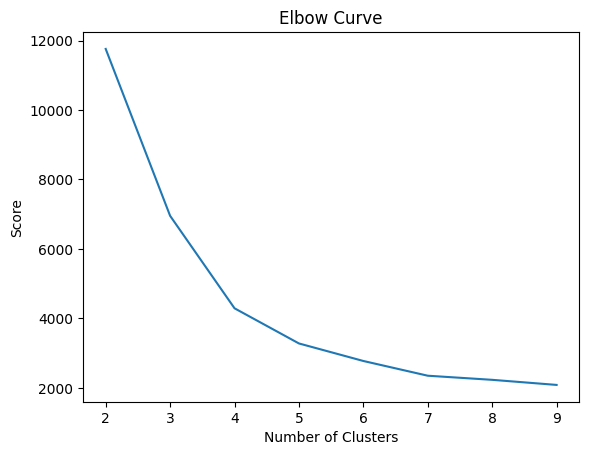

In [80]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

**Building the K-Means Clustering Model
From the plot above, we can see that there is an inflection point that looks like an elbow at four. Due to this, we will proceed to build the K-Means algorithm with four clusters:**

In [82]:
KMeans_algo=KMeans(featuresCol='standarized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [83]:
# Making Predictions
# Let’s use the model we created to assign clusters to each customer in the dataset:

preds=KMeans_fit.transform(data_scale_output)
preds.show(5,0)

+-------+---------+-------------------+----------+-----------------------------------+---------------------------------------------------------------+----------+
|recency|frequency|monetry_value      |CustomerID|features                           |standarized                                                    |prediction|
+-------+---------+-------------------+----------+-----------------------------------+---------------------------------------------------------------+----------+
|3726000|9        |155.17             |15447     |[3726000.0,9.0,155.17]             |[0.42717941487700695,0.23237755599332738,0.0555092310302321]   |2         |
|3746580|1        |-32.849999999999994|15100     |[3746580.0,1.0,-32.849999999999994]|[0.4295388760574065,0.025819728443703043,-0.011751487010009179]|2         |
|4154520|12       |155.93             |13898     |[4154520.0,12.0,155.93]            |[0.4763084870356476,0.3098367413244365,0.0557811071376174]     |2         |
|716280 |33       |208.95   

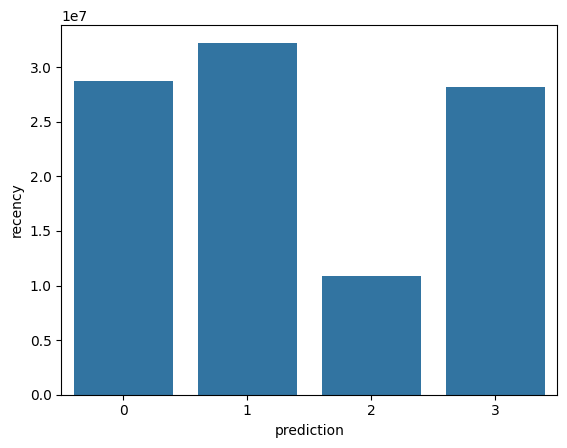

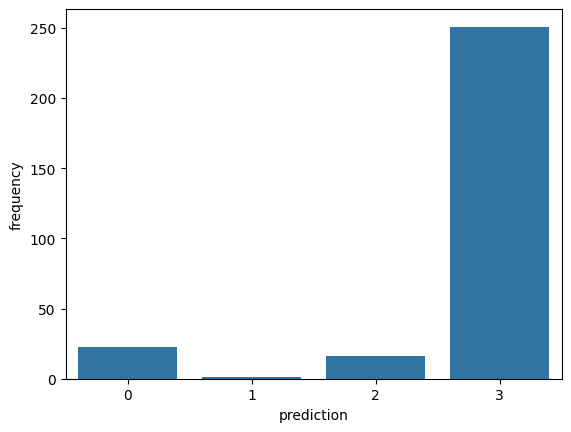

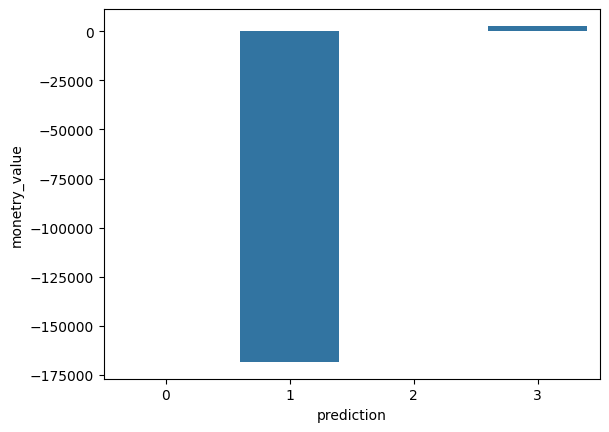

In [86]:
# Cluster Analysis
# The final step in this entire tutorial is to analyze the customer segments we just built.
# Run the following lines of code to visualize the recency, frequency, and monetary value of each customerID in the dataframe:

import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetry_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetry_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

**Cluster 0**: Customers in this segment display low recency, frequency, and monetary value.
They rarely shop on the platform and are low potential customers who are likely to stop doing business with the ecommerce company.

**Cluster 1**: Users in this cluster display high recency but haven’t been seen spending much on the platform. 
They also don’t visit the site often. This indicates that they might be newer customers who have just started doing business with the company.

**Cluster 2**: Customers in this segment display medium recency and frequency and spend a lot of money on the platform.
This indicates that they tend to buy high-value items or make bulk purchases.

**Cluster 3**: The final segment comprises users who display high recency and make frequent purchases on the platform. 
However, they don’t spend much on the platform, which might mean that they tend to select cheaper items in each purchase.